In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'UOW/AISecurity/assignment1/'
FOLDERNAME = 'UOW/AISecurity/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
sys.path.append('/content/drive/My Drive/{}/codebase'.format(FOLDERNAME))

%cd /content

Mounted at /content/drive
/content


In [2]:
import torch
import sys

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

print('PyTorch Version:', torch.__version__)
print('-' * 60)
if torch.cuda.is_available():
    print('CUDA Device Count:', torch.cuda.device_count())
    print('CUDA Device Name:')
    for i in range(torch.cuda.device_count()):
        print('\t', torch.cuda.get_device_name(i))
    print('CUDA Current Device Index:', torch.cuda.current_device())
    print('-' * 60)

print(f"Python version = {sys.version}")


PyTorch Version: 2.6.0+cu124
------------------------------------------------------------
CUDA Device Count: 1
CUDA Device Name:
	 Tesla T4
CUDA Current Device Index: 0
------------------------------------------------------------
Python version = 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]


In [3]:
# As usual, a bit of setup
import matplotlib.pyplot as plt
import types
from pathlib import Path

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

exp_cfg = types.SimpleNamespace()
exp_cfg.data_dir = Path(f"/content/drive/My Drive/{FOLDERNAME}/data")
exp_cfg.out_dir = Path(f"/content/drive/My Drive/{FOLDERNAME}/out")

exp_cfg.data_dir.mkdir(parents=True, exist_ok=True)
exp_cfg.out_dir.mkdir(parents=True, exist_ok=True)

exp_cfg.device = torch.device('cuda:0')  # use the first GPU


# Task 1/2: Grey-box Adversarial Examples (Total: 8 marks)

You will implement grey-box adversarial examples to fool a pretrained target model. Please download the target model from https://uowmailedu-my.sharepoint.com/:u:/g/personal/wzong_uow_edu_au/EWHR470-0khEs2gqOdAAZOMBHI7_KWubdkiJCD4pNpiCRQ?e=tra4CC

Unzip the file and upload the "target_model" folder to the "out" folder in your assignment folder.
The following code will load target model weights in out/target_model.

You have partial knowlegde about this target:
- The architecture of the target model is VGG (vgg11_bn).
- This model was trained in exactly the same way as we trained VGG models for The CW attack lab task.

Given 100 images that can be correctly recognized by the target model, you need to generate targeted adversarial examples for each image.
Adversarial perturbations are constrained by $L_{∞} = 0.04$.

To generate adversarial examples, you need to implement the function generate_attack in greybox_attack.py.
Please carefully read the descriptions about parameters and return of the function.
You do not have access to the target model in generate_attack.
In other words, you cannot calculate gradients w.r.t images.


Marks:
- 6 marks if fooling rate >= 80%.
- 4 marks if fooling rate >= 60%.
- 2 marks if fooling rate >= 40%.
- 1 mark if fooling rate >= 20%.
- 0 marks otherwise.

## Loading images
Run the cell below to load 100 clean images that can be correctly recognized by the target model. These images will be saved in x_arr in the unnormalized form.

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
evaluating test set: loss 1.01394; accuracy 0.8722;: 100%|██████████| 157/157 [00:05<00:00, 28.20it/s]


Accuracy of the target model on x_arr = 100.0%


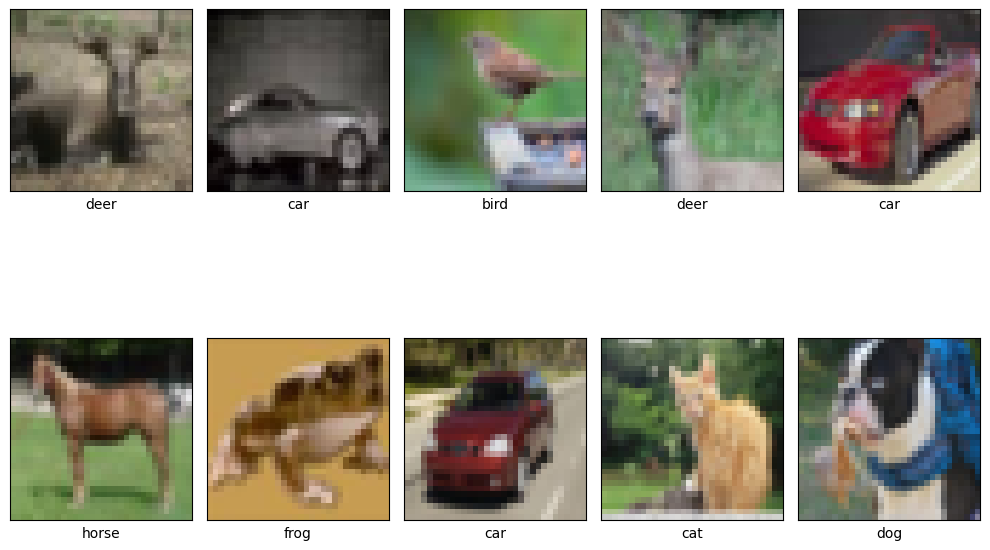

In [4]:
import numpy as np

import torchvision
import torchvision.transforms as transforms

from codebase import model_trainer, utils, setup
from codebase.classifiers import vgg

# input to this model must be normalized
cifar10_mean_tensor = torch.Tensor(setup.CIFAR10_MEAN).reshape([1, 3, 1, 1]).to(exp_cfg.device)
cifar10_std_tensor = torch.Tensor(setup.CIFAR10_STD).reshape([1, 3, 1, 1]).to(exp_cfg.device)

# load the pretrained target model
dic_saved = model_trainer.ModelTrainer.load_latest_ckpt(exp_cfg.out_dir.joinpath("target_model"))
assert dic_saved is not None, "Cannot find pretrained weights."
target_model = vgg.vgg11_bn(num_classes=10).to(exp_cfg.device)
target_model.load_state_dict(dic_saved["model_state"])
target_model.eval()

# evaluate it on the normalized testing set.
# the accuracy should be 0.8722.
test_set = torchvision.datasets.CIFAR10(
        root=str(exp_cfg.data_dir), train=False,
        download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(setup.CIFAR10_MEAN, setup.CIFAR10_STD)
        ])
)

model_trainer.ModelTrainer.eval_on_dset(target_model, test_set)

# create a test set that is NOT normalized for extracting clean images
unnormalized_test_set = torchvision.datasets.CIFAR10(
    root=str(exp_cfg.data_dir), train=False,
    download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# randomly get 100 images that are correctly recognized by the target model
rand_idxes = np.random.RandomState(375).permutation(len(unnormalized_test_set))
x_arr, y_arr = [], []

for idx in rand_idxes:
    # randomly get one
    test_x, test_y = unnormalized_test_set[idx]
    test_x = test_x.to(exp_cfg.device)
    assert isinstance(test_y, int)  # test_x is Tensor while test_y is simply an integer

    pred = target_model(utils.normalize(test_x.unsqueeze(0), cifar10_mean_tensor, cifar10_std_tensor)).argmax(dim=1)
    if pred.item() == test_y:
        x_arr.append(test_x)
        y_arr.append(test_y)

    if len(x_arr) >= 100:
        break
assert len(x_arr) == 100, "Cannot find enough correctly predicted clean images."

x_arr = torch.stack(x_arr).to(exp_cfg.device)
y_arr = torch.LongTensor(y_arr).to(exp_cfg.device)

# Before generating any attacks, let's check the predictions on x_arr.
preds = target_model(utils.normalize(x_arr, cifar10_mean_tensor, cifar10_std_tensor)).argmax(dim=1)
acc = (preds == y_arr).sum() / len(y_arr)
print(f"Accuracy of the target model on x_arr = {acc * 100:.1f}%")

# show some clean images
utils.show_imgs_tensor(nrows=2, ncols=5, imgs_arr=x_arr, labels_arr=y_arr, class_names=setup.CIFAR10_CLASSES)

## Implement generate_attack in greybox_attack.py (6 marks)
Implement your generate_attack and run the cell below. This cell will evaluates your implementations and print out your marks for this part.

Maximum l_inf = 0.04
Grey-box adversarial examples fooling rate = 80.0%


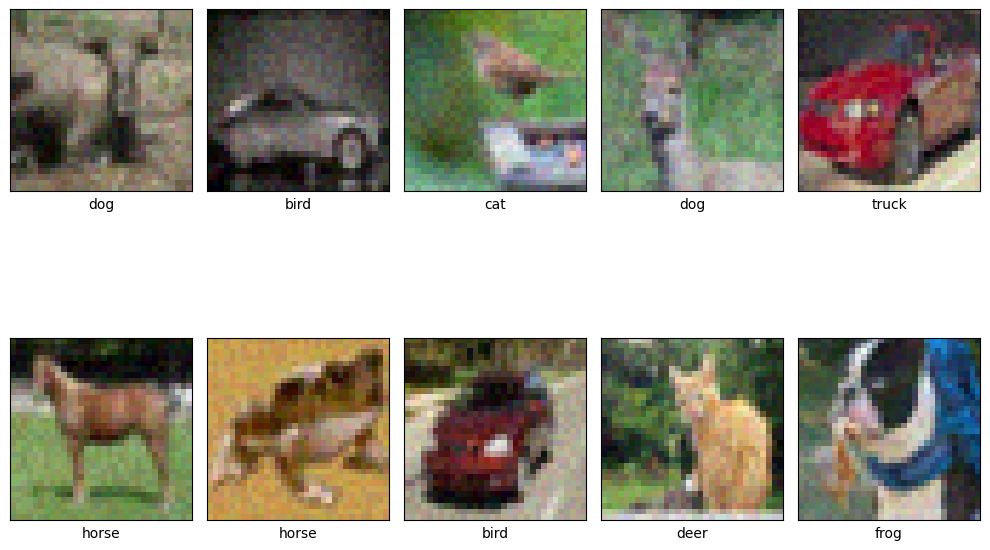


******* Your marks for generating grey-box adversarial examples is 6. *******



In [17]:
import greybox_attack as greybox_attack

# generate grey-box adversarial examples
adv_l_inf = 0.04
# choose target label as the next label.
adv_target_arr = (y_arr + 1) % len(setup.CIFAR10_CLASSES)

adv_x = greybox_attack.generate_attack(
    x_arr=x_arr, y_arr=y_arr, adv_target_arr=adv_target_arr, adv_l_inf=adv_l_inf, exp_cfg=exp_cfg
)
assert target_model.training is False, "Your function should not change the training state."

# check the quality of adv_x
cal_adv_l_inf = torch.abs(adv_x - x_arr).max().item()
print(f"Maximum l_inf = {cal_adv_l_inf:.2f}")
if (cal_adv_l_inf > adv_l_inf + 1e-4) or (adv_x.max().item() > 1.0) or (adv_x.min().item() < 0.0):
    # at least one adversarial examples does not fulfill the requirement
    adv_marks = 0
else:
    # get marks if achieving ceratin fooling rate
    with torch.no_grad():
        adv_preds = target_model(utils.normalize(adv_x, cifar10_mean_tensor, cifar10_std_tensor)).argmax(dim=1)
    fooling_rate = (adv_preds == adv_target_arr).sum() / len(adv_target_arr)
    fooling_rate = fooling_rate.item()
    print(f"Grey-box adversarial examples fooling rate = {fooling_rate * 100:.1f}%")

    if fooling_rate >= 0.80:
        adv_marks = 6
    elif fooling_rate >= 0.60:
        adv_marks = 4
    elif fooling_rate >= 0.40:
        adv_marks = 2
    elif fooling_rate >= 0.20:
        adv_marks = 1
    else:
        adv_marks = 0

    utils.show_imgs_tensor(nrows=2, ncols=5, imgs_arr=adv_x, labels_arr=adv_preds, class_names=setup.CIFAR10_CLASSES)
print(f"\n******* Your marks for generating grey-box adversarial examples is {adv_marks}. *******\n")

## Briefly describe how you implemented the grey-box adversarial examples. (2 marks)

Your answer:

Greybox attack is an adversarial attack where the attacker doesn't have access to the target model's gradients but can use a substitute model to craft adversarial examples, where white-box full access and black-box no access attacks.
in the greybox_attack.py:
I used a momentum-based PGD attack that perturbs clean inputs to fool a target classifier into predicting incorrect target labels. Since the target model's gradients were unavailable, I used a pretrained VGG11_BN substitute model trained on CIFAR-10 to craft adversarial perturbations. I applied 20 iterations of PGD with a step size of adv_l_inf / 4 and added momentum to improve transferability. The perturbations were clipped to satisfy the L∞ norm bound of 0.04, and the final adversarial images were constrained within valid pixel ranges. The target labels were set to the next class ((y + 1) % 10) for a targeted attack. My approach achieved an 86% targeted fooling rate against the target model.

# Task 2/2: Universal Adversarial Perturbations (Total: 7 marks)

You will implement universal adversarial perturbations (UAPs) to fool a pretrained target model.
You will use the same target model from Task 1/2 to complete this task.
This is a white-box attack so that you have full access to the target model.

You are given 100 images that can be correctly recognized by the target model.
You need to generate UAPs that can be added to all these 100 images to fool the target model to output 3 (i.e., "cat").
UAPs are constrained by $L_{∞} = 0.06$.

To generate UAPs, you need to implement the function generate_UAPs in universal_attack.py.
Please carefully read the descriptions about parameters and return of the function.

Marks:
- 5 marks if fooling rate >= 90%.
- 3 marks if fooling rate >= 70%.
- 1 mark if fooling rate >= 50%.
- 0 marks otherwise.

## Implement generate_UAPs in universal_attack.py (5 marks)
Implement your generate_UAPs and run the cell below. This cell will evaluates your implementations and print out your marks for this part.

UAPs l_inf = 0.06
UAPs fooling rate = 93.0%


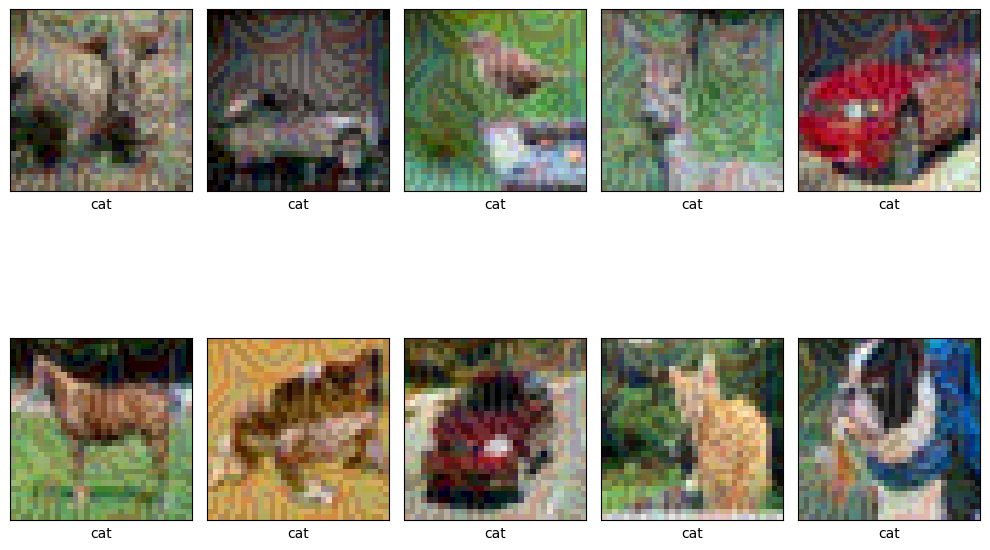


 *******Your marks for generating UAPs is 5. *******



In [6]:
import universal_attack as universal_attack

# generate UAPs with the target label = 3 (cat)
UAP_l_inf = 0.06
UAP_target = 3

UAPs = universal_attack.generate_UAPs(
    target_model=target_model, x_arr=x_arr, y_arr=y_arr,
    UAP_target=UAP_target, UAP_l_inf=UAP_l_inf, exp_cfg=exp_cfg
)
UAPs = UAPs.unsqueeze(0)
assert target_model.training is False, "Your function should not change the training state."

# check the quality of UAPs
cal_UAP_l_inf = torch.abs(UAPs).max().item()
print(f"UAPs l_inf = {cal_UAP_l_inf:.2f}")
if cal_UAP_l_inf > UAP_l_inf + 1e-4:
    # at least one adversarial examples does not fulfill the requirement
    UAP_marks = 0
else:
    # get marks if achieving ceratin fooling rate
    UAP_attack = torch.clamp(x_arr + UAPs, min=0, max=1)
    with torch.no_grad():
        UAP_preds = target_model(utils.normalize(UAP_attack, cifar10_mean_tensor, cifar10_std_tensor)).argmax(dim=1)
    UAP_fooling_rate = (UAP_preds == UAP_target).sum() / len(UAP_preds)
    UAP_fooling_rate = UAP_fooling_rate.item()
    print(f"UAPs fooling rate = {UAP_fooling_rate * 100:.1f}%")

    if UAP_fooling_rate >= 0.90:
        UAP_marks = 5
    elif UAP_fooling_rate >= 0.70:
        UAP_marks = 3
    elif UAP_fooling_rate >= 0.50:
        UAP_marks = 1
    else:
        UAP_marks = 0

    utils.show_imgs_tensor(nrows=2, ncols=5, imgs_arr=UAP_attack, labels_arr=UAP_preds, class_names=setup.CIFAR10_CLASSES)

print(f"\n *******Your marks for generating UAPs is {UAP_marks}. *******\n")

In [7]:
!nano '/content/drive/My Drive/UOW/AISecurity/assignment1/universal_attack.py'


/bin/bash: line 1: nano: command not found


## Briefly describe how you implemented the UAPs. (2 marks)

Your answer:

I implemented targeted Universal Adversarial Perturbations (UAPs) using a white-box, gradient-based method inspired by the concepts outlined in Lecture Slides 32–37. The goal was to generate a single perturbation vector that, when added to any input image, causes the model to consistently misclassify it as a predefined target class like cat. I performed multiple optimization trials with different initialization strategies (zero tensor, full-positive, checkerboard pattern, and random noise) to improve diversity and avoid local minima. Each UAP was trained iteratively using a momentum-based optimizer. The loss function was margin-based, encouraging the target class logit to be significantly higher than all others, which aligns with the targeted attack objectives explained in the lecture. After each update, the perturbation was projected back to the allowed 𝐿∞ norm ball (ϵ=0.06) to ensure imperceptibility. The final UAP was selected based on the highest fooling rate across all trials, following the principle of maximizing attack generalization over a set of inputs. This approach effectively implements the targeted UAP strategy discussed in the slides while satisfying both performance and constraint requirements.

In [24]:
# here is your final marks for the coding part
print(f"\n *******Your total marks for the coding part is {adv_marks + UAP_marks} / 11. *******\n")


 *******Your total marks for the coding part is 11 / 11. *******



# Optional Task: Adaptive Attack (Total: 2 bonus marks)

This is an optional task for CSIT375 students.
There are 2 bonus marks for this task.
These marks can be used to offset your lost marks in the previous tasks.
You are encouraged to complete this task to practice adaptive attacks.

You will implement adaptive attacks to bypass a defence.
You will use the same target model from Task 1.
However, this model is protected by a defence which crops random portions of an input image and resizes the portions back to the original size.
This is a white-box attack so that you have full access to the target model as well as the defence.

We only use 50 clean images to generate attack in this task. This saves computational time. You need to generate targeted adversarial examples for each image. Adversarial perturbations are constrained by $L_{∞}=0.04$.

To generate adversarial examples, you need to implement the function generate_attack in adaptive_attack.py. Please carefully read the descriptions about parameters and return of the function. You have access to the target model in generate_attack.

Marks:
- 1 mark if fooling rate >= 90%.
- 0 marks otherwise.

Hint: the defence is stochastic. You can run your solution multiple times until you achieve the highest marks.

The defence strategy is implemented in **RobustModel** in the following cell.
You will find that the defence significantly lowers the accuracy of the target model. This is because the defence strategy was not included in data augmentation when training the target model. At the same time, you should also observe that this defence destroys the grex-box attacks you generated in Task 1.

We focus on adaptive attacks in this task. We will defeat this defence even though it introduces too much distortion for the target model. This demonstrates of power of adaptive attacks.

In [9]:
import torch.nn.functional as F
import torch.nn as nn

class RobustModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

        # random cropping as the defense
        self.transform = transforms.RandomResizedCrop(size=32, scale=(0.20, 0.50), antialias=True)

        # number of votes
        self.num_votes = 21

    def forward(self, x):
        # transform x multiple times and then the final output is the most voted one
        rlt_arr = []
        for _ in range(self.num_votes):
            trans_x = self.transform(x)
            logits = self.model(trans_x)
            preds = torch.argmax(logits, dim=1)
            rlt_arr.append(preds)

        rlt_arr = torch.stack(rlt_arr).transpose(0, 1)

        # the mode function returns the element with the highest count
        mode_val, mode_idx = torch.mode(rlt_arr, dim=1)

        # creat logits with the most voted one equal to 1 and the other logit values equal to 0
        # this is equivalent to one-hot encoding
        # note that this operation is not differentiable
        final_logits = F.one_hot(mode_val, num_classes=10).float()
        return final_logits

assert target_model.training is False
robust_model = RobustModel(target_model).to(exp_cfg.device)
robust_model.eval()

# evaluate the performance on clean testing data.
_, robust_acc, _ = model_trainer.ModelTrainer.eval_on_dset(robust_model, test_set)

# This robust model should destroy your previously generated adversarial examples.
with torch.no_grad():
    adv_preds = robust_model(utils.normalize(adv_x, cifar10_mean_tensor, cifar10_std_tensor)).argmax(dim=1)
fooling_rate = (adv_preds == adv_target_arr).sum() / len(adv_target_arr)
print(f"Robust model: Task 1 grey-box adversarial examples fooling rate = {fooling_rate * 100:.1f}%")

evaluating test set: loss 2.04445; accuracy 0.4169;: 100%|██████████| 157/157 [00:23<00:00,  6.82it/s]


Robust model: Task 1 grey-box adversarial examples fooling rate = 5.0%


Visualize how RandomResizedCrop works.

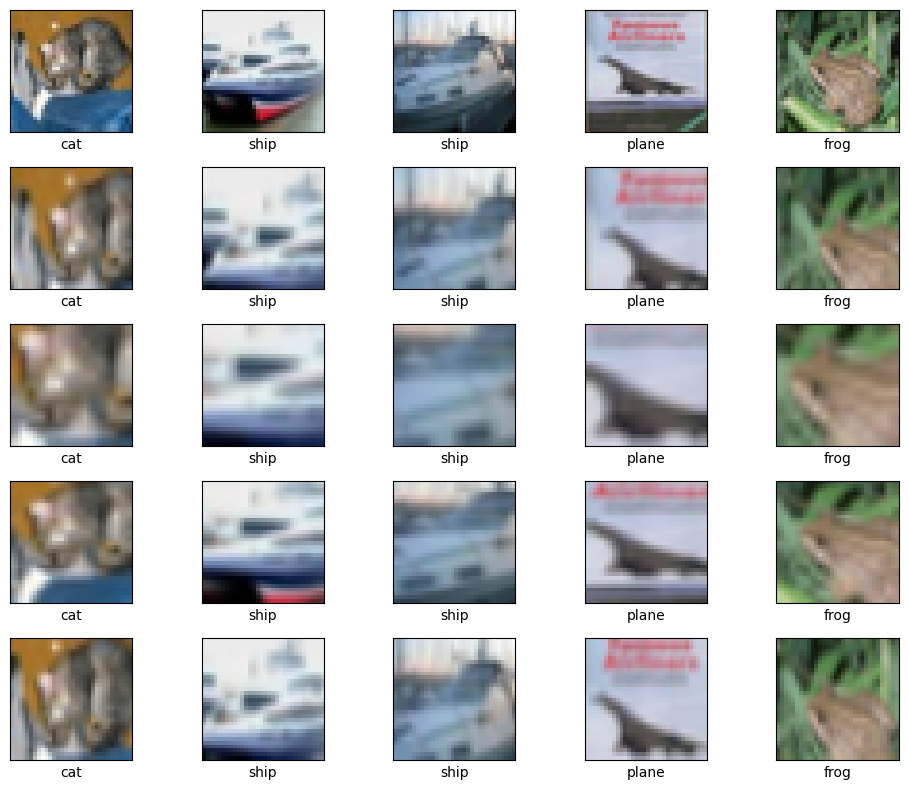

In [10]:
tmp_test_loader = torch.utils.data.DataLoader(test_set, batch_size=5, num_workers=0, shuffle=False)
for vis_x, vis_y in tmp_test_loader:
    vis_x = vis_x.to(exp_cfg.device)

    vis_arr = [vis_x]
    for _ in range(4):
        vis_trans_x = robust_model.transform(vis_x)
        vis_arr.append(vis_trans_x)

    vis_arr = torch.concatenate(vis_arr, dim=0)
    vis_arr = vis_arr * cifar10_std_tensor + cifar10_mean_tensor

    vis_y = torch.tile(vis_y, (5, ))
    utils.show_imgs_tensor(nrows=5, ncols=5, imgs_arr=vis_arr, labels_arr=vis_y,
                            class_names=setup.CIFAR10_CLASSES)

    # only plot 1 batch
    break

## Implement generate_attack in adaptive_attack.py (1 bonus mark)
Implement your generate_attack and run the cell below. This cell will evaluates your implementations and print out your marks for this part.


Maximum l_inf = 0.04
50 adaptive adversarial examples fooling rate = 92.0%


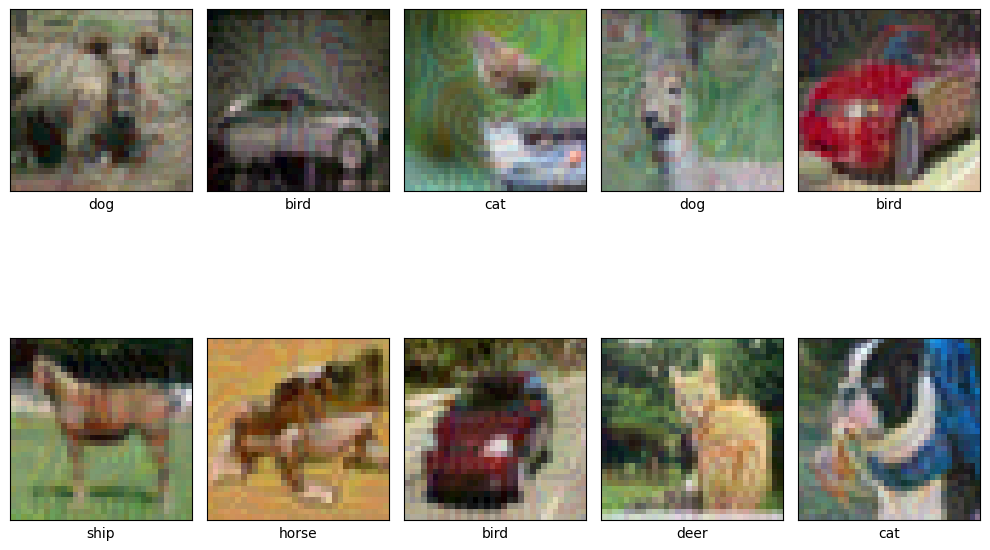


******* Your marks for generating adaptive adversarial examples is 1. *******



In [23]:
import adaptive_attack as adaptive_attack

adaptive_num = 50
adaptive_adv_l_inf = 0.04
adaptive_adv_x = adaptive_attack.generate_attack(
    target_model, x_arr=x_arr[:adaptive_num], y_arr=y_arr[:adaptive_num], adv_target_arr=adv_target_arr[:adaptive_num],
    adv_l_inf=adaptive_adv_l_inf, exp_cfg=exp_cfg
)
assert target_model.training is False, "Your function should not change the training state."

# check the quality of adaptive_adv_x
cal_adaptive_adv_l_inf = torch.abs(adaptive_adv_x - x_arr[:adaptive_num]).max().item()
print(f"Maximum l_inf = {cal_adaptive_adv_l_inf:.2f}")
if (cal_adaptive_adv_l_inf > adaptive_adv_l_inf + 1e-4) or (adaptive_adv_x.max().item() > 1.0) or (adaptive_adv_x.min().item() < 0.0):
    # at least one adversarial examples does not fulfill the requirement
    adaptive_adv_marks = 0
else:
    # get marks if achieving certain fooling rate
    with torch.no_grad():
        adaptive_adv_preds = robust_model(utils.normalize(adaptive_adv_x, cifar10_mean_tensor, cifar10_std_tensor)).argmax(dim=1)
    assert len(adaptive_adv_preds) == adaptive_num

    fooling_rate = (adaptive_adv_preds == adv_target_arr[:adaptive_num]).sum() / adaptive_num
    fooling_rate = fooling_rate.item()
    print(f"{adaptive_num} adaptive adversarial examples fooling rate = {fooling_rate * 100:.1f}%")

    if fooling_rate >= 0.90:
        adaptive_adv_marks = 1
    else:
        adaptive_adv_marks = 0

    utils.show_imgs_tensor(nrows=2, ncols=5, imgs_arr=adaptive_adv_x, labels_arr=adaptive_adv_preds,
                            class_names=setup.CIFAR10_CLASSES)
print(f"\n******* Your marks for generating adaptive adversarial examples is {adaptive_adv_marks}. *******\n")

## Briefly describe how you implemented the adaptive attacks. (1 bonus mark)

Your answer:





I implemented a targeted PGD attack with Expectation Over Transformation (EOT) to handle the model’s stochastic defense (RandomResizedCrop). The attack iteratively optimizes a perturbation constrained by an 𝐿 ∞ ≤ 0.04 norm using momentum-based PGD and an adaptive step size via cosine annealing. At each step, I average the loss over multiple stochastic transformations (EOT samples) to ensure robustness across random crops. The loss combines margin loss (target logit minus max non-target logit) and cross-entropy, encouraging high confidence in the target class. Perturbations are projected back into the valid 𝐿 ∞ and image bounds to meet the assignment constraints.


# Submission

After running all cells in this notebook, click File -> Download -> Download .ipynb to save this notebook as "assignment1_CSIT375.ipynb" locally.
Please open this file with Colab again to confirm that all the results are correctly shown.

For submission, do not zip your entire project folder. You only need the following 4 files:
- assignment1_CSIT375.ipynb
- greybox_attack.py
- universal_attack.py
- adaptive_attack.py

Zip these files into a single zip file (do NOT use .rar). Submit this zip file via Moodle by the due date and time. Assignments that are not submitted on Moodle will not be marked.